# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


### Imports

In [1]:
#Imports
from ema_workbench import (RealParameter, ScalarOutcome, Constant, Model, Policy, perform_experiments, MultiprocessingEvaluator, ema_logging, save_results, load_results)
from lakemodel_function import lake_problem

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\frac1\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\frac1\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


<Logger EMA (DEBUG)>

### Set-Up the model

In [2]:
model = Model('lakeproblem', function=lake_problem)
model.time_horizon = 100

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(model.time_horizon)]

#specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

### Perform Experiments

In [3]:
n_scenarios = 1000
n_policies = 10

with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Visualization

[MainProcess/INFO] no time dimension found in results


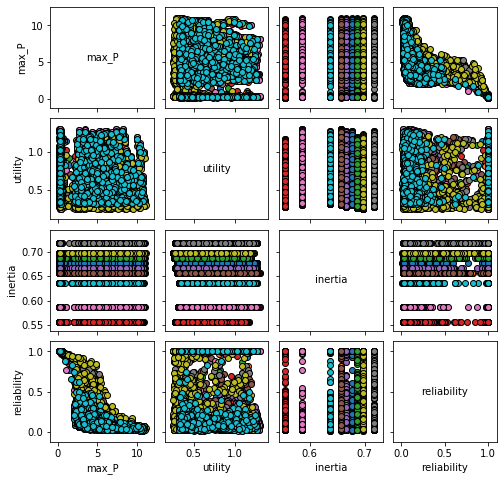

In [4]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

### Drop policy levers from Experiments dataframe and save outcomes

In [5]:
experiments_cleaned = experiments.drop(experiments.columns.to_series()["l0":"l99"], axis=1)
outcomes = pd.DataFrame(data = outcomes)
#Save experiments and outcomes file
experiments_cleaned.to_csv(r"results/experiments.csv", index = False)
outcomes.to_csv(r"results/outcomes.csv", index = False)

#Load them again
experiments = pd.read_csv("results/experiments.csv")
outcomes = pd.read_csv("results/outcomes.csv")

## Scenario Discovery

In [27]:
from ema_workbench.analysis import prim

x = experiments
y = outcomes['reliability'] < outcomes['reliability'].quantile(0.1) #I select only the 10% of outcoemes with lowest reliability
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 760 cases of interest
[MainProcess/INFO] mean: 0.8666666666666667, mass: 0.051, coverage: 0.5815789473684211, density: 0.8666666666666667 restricted_dimensions: 3


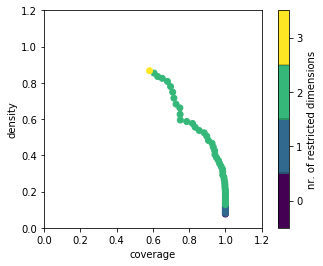

In [28]:
box1.show_tradeoff()
plt.show()

coverage    0.786842
density     0.586275
id                43
mass           0.102
mean        0.586275
res_dim            2
Name: 43, dtype: object

     box 43                                           
        min       max                        qp values
q  2.002158  2.594104  [-1.0, 1.4144475852593854e-214]
b  0.100290  0.264569  [-1.0, 1.5241400777598784e-105]



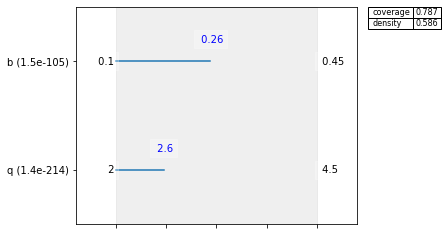

In [40]:
box1.inspect(43)
box1.inspect(43, style='graph')
plt.show()

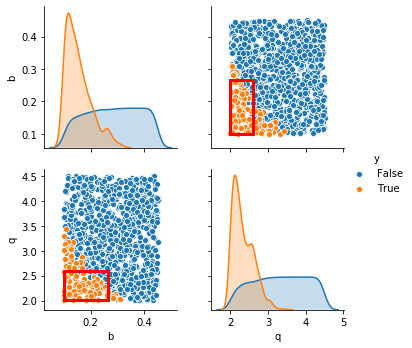

In [39]:
box1.show_pairs_scatter(43)
plt.show()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category


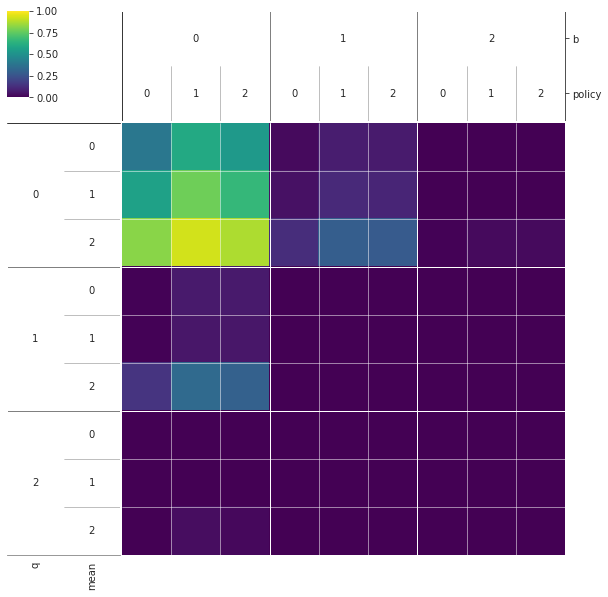

In [39]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = outcomes['reliability'] < outcomes['reliability'].quantile(0.1)
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()